In [4]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
from utils import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


/usr/local/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Generator']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Configuration

In [5]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False
gpu = 0

In [6]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [7]:
#-------------------------------------------
#Choose the Model you want!
# from Model_alphaWGAN import *
# from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
from Model_VAEGAN import Generator
from Model_VAEGAN import Encoder
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda(gpu)
# E = Encoder(out_class = latent_dim).cuda(gpu)
E = Discriminator(out_class = latent_dim, is_dis=False).cuda(gpu)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/G_iter188500.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
G.load_state_dict(torch.load('./vae_checkpoint_1/G_VG_ep_100.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./checkpoint/Alpha_G.pth')) #Alpha-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

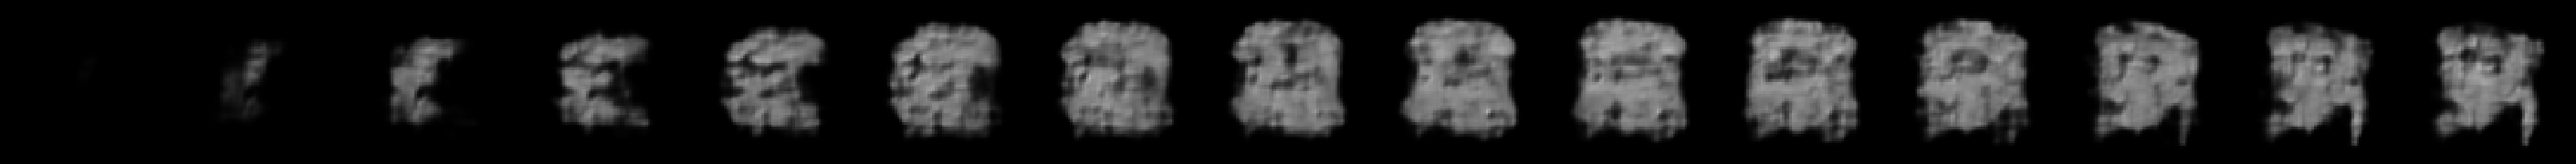

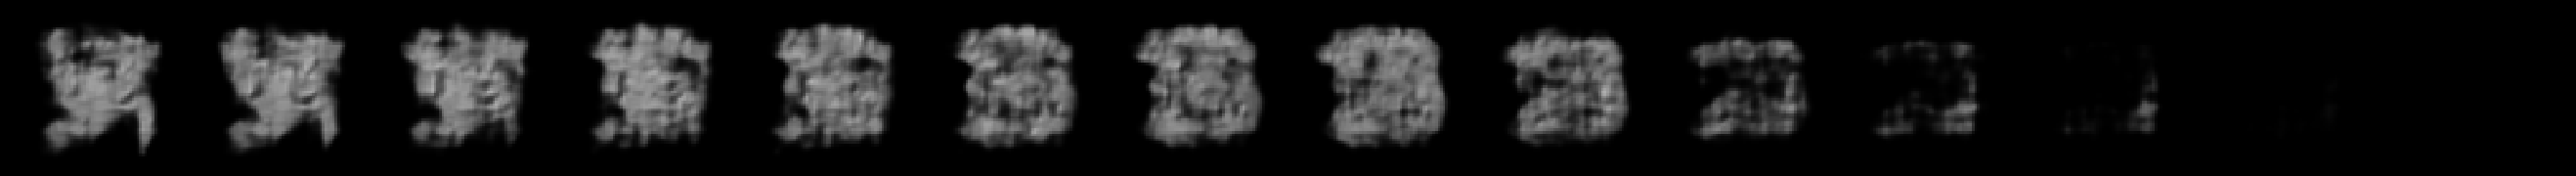

In [20]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda(gpu)
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

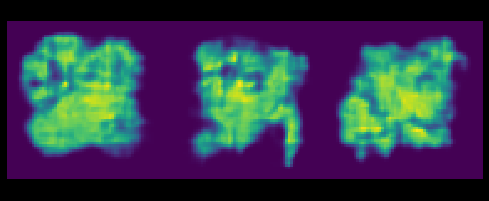

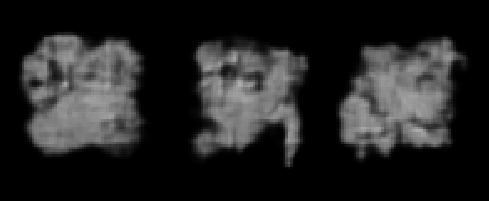

In [21]:
noise = Variable(torch.randn((1, 1000)).cuda(gpu))
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
gen_load = inf_train_gen(train_loader)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# MS-SSIM Calculation

In [ ]:
# sum_ssim = 0
# for k in range(20):
#     for i,dat in enumerate(train_loader):
#         if len(dat)!=2:
#             break
#         img1 = dat[0]
#         img2 = dat[1]

#         msssim = pytorch_ssim.msssim_3d(img1,img2)  
#         sum_ssim = sum_ssim+msssim
#     print(sum_ssim/((k+1)*(i+1)))

In [86]:
G.load_state_dict(torch.load('./vae_checkpoint_2/G_VG_ep_119.pth'))
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda(gpu))
    fake_image = G(noise)

    img1 = fake_image[0]
    img2 = fake_image[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(f'final ssim: {sum_ssim/1000}')

tensor(0.0006, device='cuda:0')
tensor(0.0784, device='cuda:0')
tensor(0.1572, device='cuda:0')
tensor(0.2363, device='cuda:0')
tensor(0.3148, device='cuda:0')
tensor(0.3947, device='cuda:0')
tensor(0.4744, device='cuda:0')
tensor(0.5528, device='cuda:0')
tensor(0.6307, device='cuda:0')
tensor(0.7083, device='cuda:0')
final ssim: 0.7856695652008057


# MS-SSIM for real images

In [33]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

KeyboardInterrupt: 

# Maximum-Mean Discrepancy Score

### calculate mmd

In [ ]:
# try different variances for z_e
var = [0.1, 1, 2, 5, 10, 20, 30, 50, 100]
# for i in range(len(var)-1, -1, -1):
# for i in range(162500, 200000, 2000):
#     G.load_state_dict(torch.load(f'./checkpoint/G_iter{i}.pth'))
#     calc_mmd(train_loader, G, i, gpu_ind=gpu, path='test_data')
G.load_state_dict(torch.load(f'./vae_checkpoint_1/G_VG_ep_100.pth'))
calc_mmd(train_loader, G, 0, count=100, gpu_ind=gpu, path='test_data', no_write=True)


Count: 0 Mean: 996.6655745967741

Count: 0 Mean: 929.3374495967741

Count: 0 Mean: 964.0201612903226

Count: 0 Mean: 927.4495967741935

Count: 0 Mean: 1034.0126008064517

Count: 0 Mean: 947.8543346774194

Count: 0 Mean: 952.3530745967741

Count: 0 Mean: 936.8291330645161

Count: 0 Mean: 963.616683467742

Count: 0 Mean: 964.5095766129032

Count: 0 Mean: 905.039566532258

Count: 0 Mean: 996.4309475806451

Count: 0 Mean: 965.5612399193549

Count: 0 Mean: 966.2321068548387

Count: 0 Mean: 996.5181451612904

Count: 0 Mean: 1007.0360383064516

Count: 0 Mean: 964.7726814516129

Count: 0 Mean: 986.7174899193549

Count: 0 Mean: 914.7726814516129

Count: 0 Mean: 977.647933467742

Count: 0 Mean: 929.1204637096774

Count: 0 Mean: 997.7046370967741

Count: 0 Mean: 878.7903225806451

Count: 0 Mean: 1061.1522177419354

Count: 0 Mean: 1007.5720766129032

Count: 0 Mean: 905.1005544354839

Count: 0 Mean: 937.7001008064516


In [70]:
for i in range(199, -1, -10):
    G.load_state_dict(torch.load(f'./vae_checkpoint_2/G_VG_ep_{i}.pth'))
#     G.load_state_dict(torch.load(f'./checkpoint/G_iter{i}.pth'))
#     E.load_state_dict(torch.load(f'./mmd_checkpoint/E_iter{i}.pth'))
    calc_mmd(train_loader, G, i, count=1, gpu_ind=gpu, path='vae_checkpoint_1', no_write=False)


Count: 119 Mean: 2732.624495967742

Count: 109 Mean: 2801.6164944556454

Count: 99 Mean: 2902.040574596774

Count: 89 Mean: 2954.0558845766127

Count: 79 Mean: 2975.446824596774

Count: 69 Mean: 2920.5535534274195

Count: 59 Mean: 3320.2113155241937

Count: 49 Mean: 3293.5764238911293

Count: 39 Mean: 3476.5506552419356

Count: 29 Mean: 3705.4756804435483

Count: 19 Mean: 3852.3033644153224

Count: 9 Mean: 4282.781628024193


### visualize mmd curve

In [ ]:
df = load_csv('./trained/wl_gan_mmd.csv')
plt.figure()
df['mmd_score'].plot()

### Images PCA Visualization

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 122, sample_mean: -0.862160325050354 sample_var: 0.05033204331994057, yellow_mean: -0.8591275811195374 yellow_var: 0.05620811879634857


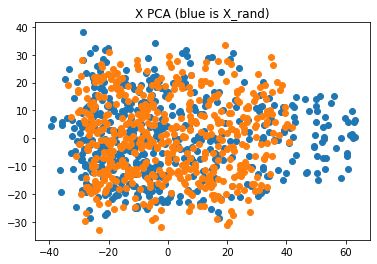

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 112, sample_mean: -0.8634554147720337 sample_var: 0.04803915694355965, yellow_mean: -0.8597186207771301 yellow_var: 0.05576827749609947


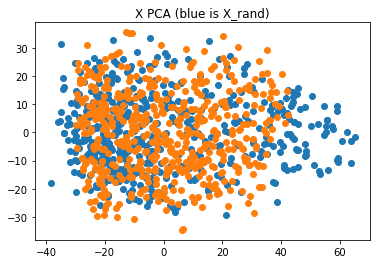

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 102, sample_mean: -0.868219256401062 sample_var: 0.04606098309159279, yellow_mean: -0.858338475227356 yellow_var: 0.05664661526679993


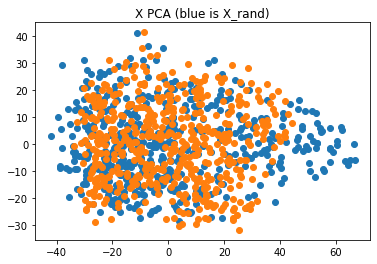

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 92, sample_mean: -0.867392897605896 sample_var: 0.04471932351589203, yellow_mean: -0.8594548106193542 yellow_var: 0.055882588028907776


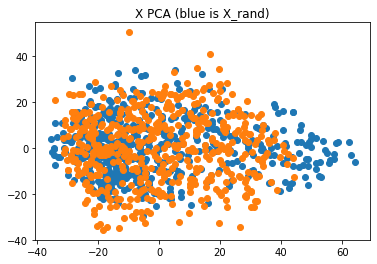

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 82, sample_mean: -0.8604471683502197 sample_var: 0.049365848302841187, yellow_mean: -0.8581779599189758 yellow_var: 0.05688606947660446


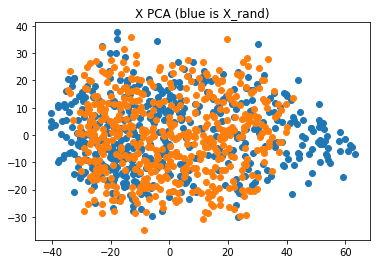

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 72, sample_mean: -0.859491229057312 sample_var: 0.04955931752920151, yellow_mean: -0.8599247336387634 yellow_var: 0.0556018203496933


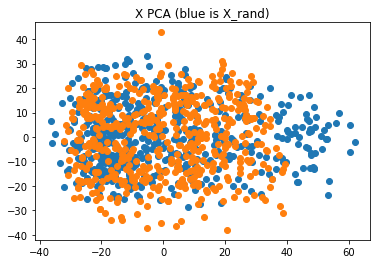

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


index: 62, sample_mean: -0.8595935106277466 sample_var: 0.04940488189458847, yellow_mean: -0.8591204285621643 yellow_var: 0.056129395961761475


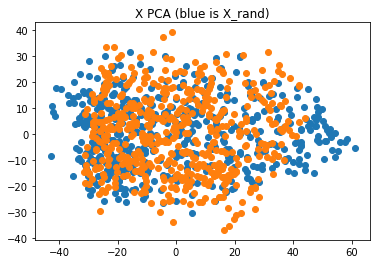

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
# for i in range(196000, 0, -2000):
for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./vae_checkpoint_2/G_VG_ep_{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1))
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [ ]:
viz_all_imgs('../../ADNI', [0])

### loss check

<AxesSubplot:>

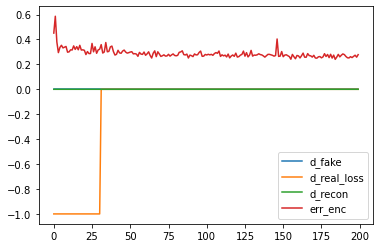

<Figure size 28800x28800 with 0 Axes>

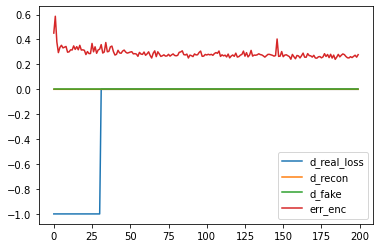

In [87]:
loss_df = load_loss(path='./vae_checkpoint_2/loss.csv')
# print(loss_df)
# alpha_wgan
loss_df[['d_fake', 'd_real_loss', 'd_recon', 'err_enc']].plot() 
# vae_gan
# loss_df[['d_real_loss', 'd_fake', 'd_recon', 'err_enc']].plot() 

# plt.figure()
# # loss_df[['loss1', 'mmd_loss']].plot()
# plt.figure()
# loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()
plt.figure(figsize=(400, 400))
loss_df.plot()

### latent vector pca

In [ ]:
E.load_state_dict(torch.load(f'./checkpoint/E_iter33500.pth'))
viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True)

<Figure size 432x288 with 0 Axes>

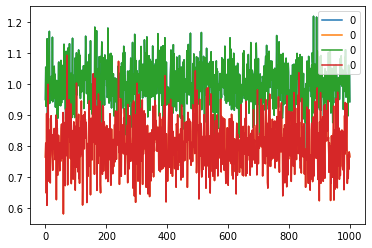

index: 100, sample_mean: 0.006653747987002134 sample_var: 0.8789551258087158, yellow_mean: 0.00048705609515309334 yellow_var: 1.0029163360595703


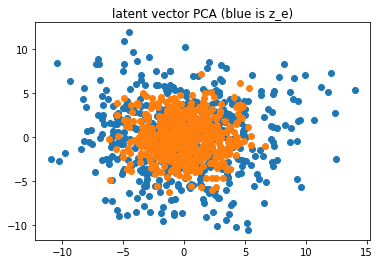

<Figure size 432x288 with 0 Axes>

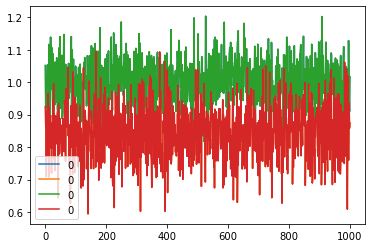

index: 90, sample_mean: -0.0014567391481250525 sample_var: 0.901488184928894, yellow_mean: 0.0008254039566963911 yellow_var: 1.0006296634674072


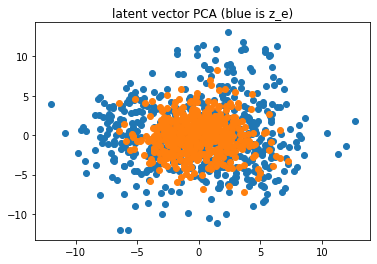

<Figure size 432x288 with 0 Axes>

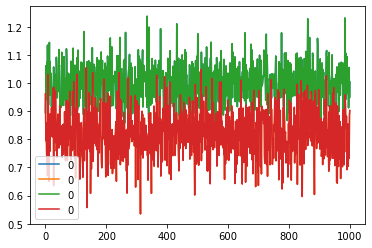

index: 80, sample_mean: 0.003673180937767029 sample_var: 0.8817150592803955, yellow_mean: 0.0005380789516493678 yellow_var: 1.0000969171524048


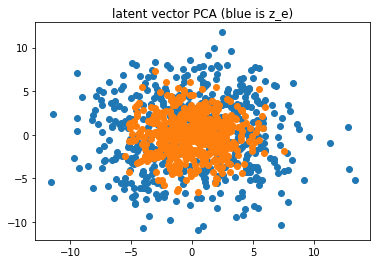

KeyboardInterrupt: 

In [32]:
# for VAEGAN
for i in range(100, -1, -10):
    E.load_state_dict(torch.load(f'./vae_checkpoint_1/E_VG_ep_{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu, batch_size=1)

In [ ]:
# for AlphaWGAN
for i in range(100000, 0, -2000):
    E.load_state_dict(torch.load(f'./mmd_checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu)

# Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda(gpu)
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda(gpu)
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

In [ ]:
%debug

In [ ]:
from utils import sinkhorn_pointcloud as sp
import numpy as np
import torch
from ipdb import set_trace
from torch import optim
from torch.autograd import Variable

gpu=1
a = Variable(torch.randn((1000, 4)).cuda(gpu), requires_grad=True)
b = Variable(torch.randn((1000, 4)).cuda(gpu) * 0.01, requires_grad=True) 
g_optimizer = optim.Adam([a, b], lr=0.0002)
print(a.shape, b.shape)
for i in range(1000):
    g_optimizer.zero_grad()
    w_dist = sp.sinkhorn_loss(a, b, 0.1, 1000, 100, gpu=gpu)
    w_dist.backward()
    g_optimizer.step()
    
    if i % 100 == 0:
        print(w_dist)

In [ ]:
a = torch.randn((1, 5), requires_grad=True)
c = a * 2
c.requires_grad = True;
b = c.sum()
b.backward()
print(a.grad)
print(c.grad)
print(b.grad)
